In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import Model


In [2]:
class CONFIG:
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    COLOR_CHANNELS = 3
    NOISE_RATIO = .6
    MEAN = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    


In [3]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):

    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image

def gramsMatrix(output):
    flatten = tf.reshape(output,(-1,output.shape[-1]))
    gmat = tf.matmul(tf.transpose(flatten),flatten)
    return gmat

# VGG MODEL
 
 
 Neural Style Transfer using VGG Model 
 
 
 

In [4]:
vgg_model = tf.keras.applications.VGG16(weights = 'weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [6]:
content_path = "images/buet_ece.jpg"
style_path = 'images/vincent.jpg'

content_image = (cv2.resize(plt.imread(content_path),(224,224),interpolation=cv2.INTER_AREA))
content_image = np.expand_dims(content_image,axis=0)
content_image = tf.Variable(content_image - CONFIG.MEAN , dtype=tf.float32)
style_image = (cv2.resize(plt.imread(style_path),(224,224),interpolation=cv2.INTER_AREA))
style_image = np.expand_dims(style_image,axis=0) - CONFIG.MEAN
style_image = tf.Variable(style_image,dtype=tf.float32)
input_image = tf.Variable(generate_noise_image(content_image,noise_ratio=.6),dtype=tf.float32)
content_layer = 15
alpha = .6
beta = .004
style_layer_index = [6,12,14,16]


In [7]:
for layer in vgg_model.layers:
    layer.trainable = False

style_output_model = Model(vgg_model.input,[vgg_model.layers[i].output for i in style_layer_index])
content_output_model = Model(vgg_model.input,vgg_model.layers[content_layer].output)

In [10]:
alpha = .4
beta = .6
opt = tf.keras.optimizers.SGD(learning_rate=0.0001,momentum = .9)
# opt = tf.keras.optimizers.Adam(learning_rate = .1)
# input_image = tf.Variable(generate_noise_image(content_image,noise_ratio=1),dtype=tf.float32)


content_output = content_output_model(content_image)
content_output = tf.keras.backend.flatten(content_output)
style_output = style_output_model(style_image)

for j in range(100):    
    with tf.GradientTape() as tape:
        input_content_output = content_output_model(input_image)
        input_content_output = tf.keras.backend.flatten(input_content_output)

        content_cost =  (alpha / 2 ) * tf.square(tf.norm(input_content_output - content_output))

        input_style_output = style_output_model(input_image)

        style_cost = tf.Variable(0,dtype=tf.float32)

        for i in range(len(style_layer_index)):
            input_l_g = gramsMatrix(input_style_output[i])
            style_l_g = gramsMatrix(style_output[i]) 
            _,nh,nw,nc = style_output[i].shape
            style_cost = style_cost + (1 / (2*nh*nw*nc)**2) * tf.square(tf.norm(tf.keras.backend.flatten(input_l_g) - tf.keras.backend.flatten(style_l_g)))
            
        
        total_cost = content_cost + beta * style_cost

    print("epoch : ",j+1, "cost : ",total_cost.numpy() ,"content cost : ",content_cost.numpy(),"style cost : ",style_cost.numpy())
    opt.apply_gradients(zip([tape.gradient(total_cost,input_image)],[input_image]))
#     print(tape.gradient(style_cost,input_image))
#     break



epoch :  1 cost :  13701821000.0 content cost :  28463888.0 style cost :  22788927000.0
epoch :  2 cost :  13327839000.0 content cost :  28157054.0 style cost :  22166137000.0
epoch :  3 cost :  12531767000.0 content cost :  28306506.0 style cost :  20839100000.0
epoch :  4 cost :  11219760000.0 content cost :  29330154.0 style cost :  18650716000.0
epoch :  5 cost :  9307885000.0 content cost :  31022228.0 style cost :  15461436000.0
epoch :  6 cost :  6839122400.0 content cost :  33405604.0 style cost :  11342861000.0
epoch :  7 cost :  4206600000.0 content cost :  36859356.0 style cost :  6949567500.0
epoch :  8 cost :  2351419600.0 content cost :  41366170.0 style cost :  3850088700.0
epoch :  9 cost :  2372700400.0 content cost :  46677144.0 style cost :  3876705300.0
epoch :  10 cost :  4072729900.0 content cost :  51587700.0 style cost :  6701903400.0
epoch :  11 cost :  5252000300.0 content cost :  54502310.0 style cost :  8662496000.0
epoch :  12 cost :  4321701000.0 content c

epoch :  97 cost :  88804110.0 content cost :  29406496.0 style cost :  98996024.0
epoch :  98 cost :  88120420.0 content cost :  29289300.0 style cost :  98051860.0
epoch :  99 cost :  87456510.0 content cost :  29174880.0 style cost :  97136040.0
epoch :  100 cost :  86809860.0 content cost :  29062310.0 style cost :  96245900.0


(224, 224, 3)


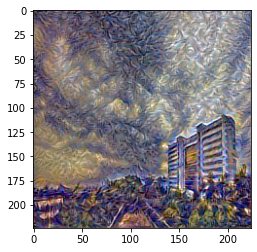

In [11]:
img_arr = np.squeeze(input_image.numpy() + CONFIG.MEAN)
img_arr[img_arr > 255.0] = 255
img_arr[img_arr < 0.0] = 0
img_arr = img_arr.astype(np.uint8)
plt.imshow(img_arr)
print(img_arr.shape)
plt.imsave("results/buet_ece_vincen.jpg",img_arr)
# im = Image.fromarray(img_arr)
# im.save("test.jpg")

In [ ]:
test = plt.imread(content_path)
plt.imshow(test)
print(test.shape)

# YOLO MODEL

Neural Style Transfer using yolo model

In [12]:
class CONFIG:
    IMAGE_WIDTH = 608
    IMAGE_HEIGHT = 608
    COLOR_CHANNELS = 3
    NOISE_RATIO = .6
    


In [13]:
class yoloLayer(tf.keras.layers.Layer):
    
    def get_config(self):

        config = {
            'n_classes' : self.n_classes,
            'anchors' : self.anchors,
            'img_size' : self.img_size
        }
        base_config = super(yoloLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def __init__(self,n_classes,anchors,img_size,**kwargs):
        super(yoloLayer,self).__init__(**kwargs)
        self.n_classes = n_classes
        self.anchors = anchors
        self.img_size = img_size

    def call(self,inputs):
        n_anchors = len(self.anchors)
        shape = inputs.get_shape().as_list()
        grid_shape = shape[1:3]
        inputs = tf.reshape(inputs,[-1,n_anchors*grid_shape[0]*grid_shape[1],5+self.n_classes])
        strides = (self.img_size[0]//grid_shape[0],self.img_size[1]//grid_shape[1])
        box_centers,box_shapes,confidence,classes = tf.split(inputs,[2,2,1,self.n_classes],axis=-1)
        x = tf.range(grid_shape[0],dtype=tf.float32)
        y = tf.range(grid_shape[1],dtype=tf.float32)
        x_offset,y_offset = tf.meshgrid(x,y)
        x_offset = tf.reshape(x_offset,(-1,1))
        y_offset = tf.reshape(y_offset,(-1,1))
        x_y_offset = tf.concat([x_offset,y_offset],axis=-1)
        x_y_offset = tf.tile(x_y_offset,[1,n_anchors])
        x_y_offset = tf.reshape(x_y_offset,[1,-1,2])
        box_centers = tf.keras.activations.sigmoid(box_centers)
        box_centers = (box_centers+x_y_offset)*strides

        anchors = tf.tile(self.anchors,[grid_shape[0]*grid_shape[1],1])
        box_shapes = tf.exp(box_shapes) * tf.cast(anchors,dtype=tf.float32)
        confidence = tf.keras.activations.sigmoid(confidence)
        classes = tf.keras.activations.sigmoid(classes)
        return tf.concat([box_centers,box_shapes,confidence,classes],axis=-1)


class upsample(tf.keras.layers.Layer):

    def get_config(self):

        config = {
          'out_shape': self.out_shape
        }
        base_config = super(upsample, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def __init__(self,out_shape,**kwargs):
        super(upsample,self).__init__(**kwargs)
        self.out_shape = out_shape

    def call(self,input):
        new_height = self.out_shape[2]
        new_width = self.out_shape[1]
        input = tf.image.resize(input,(new_width,new_height),method='nearest')
        return input



In [14]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):

    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image

def gramsMatrix(output):
    flatten = tf.reshape(output,(-1,output.shape[-1]))
    gmat = tf.matmul(tf.transpose(flatten),flatten)
    return gmat

In [16]:
yolo_model = tf.keras.models.load_model("../Object Detection (yolo v3)/saved models/yolo.h5",
                                        custom_objects = {'yoloLayer':yoloLayer,'upsample' : upsample})

In [ ]:
yolo_model.summary()

In [17]:
for layer in yolo_model.layers:
    print(layer.name)

input
conv0
batch0
leaky_re_lu_72
tf_op_layer_Pad_5
conv1
batch1
leaky_re_lu_73
conv2
batch2
leaky_re_lu_74
conv3
batch3
leaky_re_lu_75
tf_op_layer_add_23
tf_op_layer_Pad_6
conv4
batch4
leaky_re_lu_76
conv5
batch5
leaky_re_lu_77
conv6
batch6
leaky_re_lu_78
tf_op_layer_add_24
conv7
batch7
leaky_re_lu_79
conv8
batch8
leaky_re_lu_80
tf_op_layer_add_25
tf_op_layer_Pad_7
conv9
batch9
leaky_re_lu_81
conv10
batch10
leaky_re_lu_82
conv11
batch11
leaky_re_lu_83
tf_op_layer_add_26
conv12
batch12
leaky_re_lu_84
conv13
batch13
leaky_re_lu_85
tf_op_layer_add_27
conv14
batch14
leaky_re_lu_86
conv15
batch15
leaky_re_lu_87
tf_op_layer_add_28
conv16
batch16
leaky_re_lu_88
conv17
batch17
leaky_re_lu_89
tf_op_layer_add_29
conv18
batch18
leaky_re_lu_90
conv19
batch19
leaky_re_lu_91
tf_op_layer_add_30
conv20
batch20
leaky_re_lu_92
conv21
batch21
leaky_re_lu_93
tf_op_layer_add_31
conv22
batch22
leaky_re_lu_94
conv23
batch23
leaky_re_lu_95
tf_op_layer_add_32
conv24
batch24
leaky_re_lu_96
conv25
batch25
leaky

In [18]:
content_path = "images/buet_ece.jpg"
style_path = 'images/vincent.jpg'

img_size = (608,608)

content_image = (cv2.resize(plt.imread(content_path),img_size,interpolation=cv2.INTER_AREA))
content_image = np.expand_dims(content_image,axis=0) / 255.0
content_image = tf.Variable(content_image, dtype=tf.float32)
style_image = (cv2.resize(plt.imread(style_path),img_size,interpolation=cv2.INTER_AREA))
style_image = np.expand_dims(style_image,axis=0) / 255.0
style_image = tf.Variable(style_image,dtype=tf.float32)
input_image = tf.Variable(generate_noise_image(content_image,noise_ratio=.6)/255.0,dtype=tf.float32)
content_layer = 'conv60'
alpha = .6
beta = .4
style_layer_name = ['conv30']
#                     ,'conv40','conv50','conv60','conv70']


In [19]:
for layer in yolo_model.layers:
    layer.trainable = False

style_output_model = Model(yolo_model.input,[yolo_model.get_layer(i).output for i in style_layer_name])
content_output_model = Model(yolo_model.input,yolo_model.get_layer(content_layer).output)

In [20]:
content_output_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 608, 608, 32) 864         input[0][0]                      
__________________________________________________________________________________________________
batch0 (BatchNormalization)     (None, 608, 608, 32) 128         conv0[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_72 (LeakyReLU)      (None, 608, 608, 32) 0           batch0[0][0]                     
____________________________________________________________________________________________

In [21]:
alpha = .4
beta = .6
opt = tf.keras.optimizers.SGD(learning_rate=0.01,momentum = .9)
# opt = tf.keras.optimizers.Adam(learning_rate = .1)
# input_image = tf.Variable(generate_noise_image(content_image,noise_ratio=1),dtype=tf.float32)


content_output = content_output_model(content_image)
content_output = tf.keras.backend.flatten(content_output)
style_output = style_output_model(style_image)

for j in range(10):    
    with tf.GradientTape() as tape:
        input_content_output = content_output_model(input_image)
        input_content_output = tf.keras.backend.flatten(input_content_output)

        content_cost =  (alpha / 2 ) * tf.square(tf.norm(input_content_output - content_output))

        input_style_output = style_output_model(input_image)

        style_cost = tf.Variable(0,dtype=tf.float32)

        for i in range(len(style_layer_index)):
            input_l_g = gramsMatrix(input_style_output[i])
            style_l_g = gramsMatrix(style_output[i]) 
            _,nh,nw,nc = style_output[i].shape
            style_cost = style_cost + (1 / (2*nh*nw*nc)**2) * tf.square(tf.norm(tf.keras.backend.flatten(input_l_g) - tf.keras.backend.flatten(style_l_g)))
            
        
        total_cost = content_cost + beta * style_cost

    print("epoch : ",j+1, "cost : ",total_cost.numpy() ,"content cost : ",content_cost.numpy(),"style cost : ",style_cost.numpy())
    opt.apply_gradients(zip([tape.gradient(total_cost,input_image)],[input_image]))
#     print(tape.gradient(style_cost,input_image))
#     break



ResourceExhaustedError:  OOM when allocating tensor with shape[1,152,152,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node add_24 (defined at <ipython-input-21-c833a61c4800>:8) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference__defun_call_60407]

Function call stack:
_defun_call
